# Notebook Summary

* feature extraction using transfer learning (we use ResNet and EfficientNet) 
* tensorflow hub
* tensorboard callback

In [ ]:
import zipfile 

from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/CNN/10_food_classes_all_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: 10_food_classes_all_data/train/hamburger/2119225.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._2119225.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/22923.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._22923.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/3894442.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._3894442.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/1101890.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._1101890.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/2715888.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._2715888.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/554363.jpg  
  inflating: __MACOSX/10_food_classes_all_data/train/hamburger/._554363.jpg  
  inflating: 10_food_classes_all_data/train/hamburger/2100953.jpg  
  inf

In [ ]:
import os

class_names = os.listdir("food_dataset/train/")

class_names.sort()

class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Setting train and test directory paths

train_dir = "food_dataset/train/"

test_dir = "food_dataset/test/"

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.)

test_datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               shuffle = True) 

test_data = test_datagen.flow_from_directory(test_dir,
                                             batch_size = 32,
                                             target_size = (224,224),
                                             class_mode = "categorical",
                                             shuffle = True)


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
# Seeing the images

images,labels = train_data.next()

(-0.5, 223.5, 223.5, -0.5)

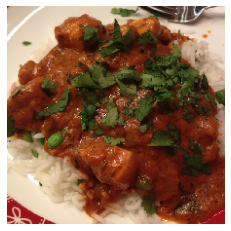

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[2])
plt.axis("off")

### Tensorboard callback

In [ ]:
# Making a funciton to save logs of tensorboard

from datetime import datetime
 
def create_tensorboard_callback(dir_name,experiment_name):

  log_dir = dir_name+"/"+experiment_name+"/"+datetime.now().strftime("%Y%m%d-%H%M%S")

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  print(f"Saving the logs to :- {log_dir} ")

  return tensorboard_callback

### Tensorflow Hub

In [ ]:
import tensorflow_hub as hub

resnet_model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Function to create the model

# Creating custom docstring as well

def create_model(model_url,num_classes = 10):
  """
  Args:
    model_url - URL of the model from Tensorflow Hub.

    num_classes - The number of classes in our classification problem.

  Returns:
    An uncompiled Keras Sequential Model
  """
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable= False,
                                            name = "feature_extraction_layer",
                                            input_shape = (224,224,3))
  
  model = tf.keras.Sequential([
                          feature_extraction_layer,
                          tf.keras.layers.Dense(num_classes,activation = "softmax",name = "output_layer")
  ])

  return model

In [ ]:
# MAKING THE MODELS

resnet_model = create_model(resnet_model_url)

efficientnet_model = create_model(efficientnet_model_url)


### Resnet Model

In [ ]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = "Adam",
                     metrics = ["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  
                                  callbacks = [create_tensorboard_callback("tensorflow_hub","resnet50v2")])

Saving the logs to :- tensorflow_hub/resnet50v2/20210513-204520 
Epoch 1/5
235/235 [==============================] - 51s 216ms/step - loss: 0.8960 - accuracy: 0.7129 - val_loss: 0.5209 - val_accuracy: 0.8248
Epoch 2/5
235/235 [==============================] - 48s 204ms/step - loss: 0.5388 - accuracy: 0.8221 - val_loss: 0.4922 - val_accuracy: 0.8292
Epoch 3/5
235/235 [==============================] - 48s 203ms/step - loss: 0.4396 - accuracy: 0.8536 - val_loss: 0.4789 - val_accuracy: 0.8376
Epoch 4/5
235/235 [==============================] - 48s 203ms/step - loss: 0.3725 - accuracy: 0.8777 - val_loss: 0.4643 - val_accuracy: 0.8496
Epoch 5/5
235/235 [==============================] - 47s 202ms/step - loss: 0.3239 - accuracy: 0.8975 - val_loss: 0.4578 - val_accuracy: 0.8436


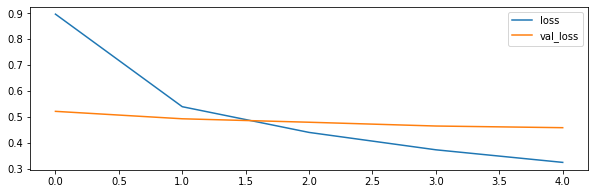

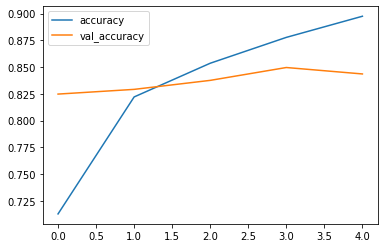

In [ ]:
# Plotting loss and accuracy curves for resnet

loss = resnet_history.history["loss"]
val_loss = resnet_history.history["val_loss"]

accuracy = resnet_history.history["accuracy"]
val_accuracy = resnet_history.history["val_accuracy"]

num_of_epochs = range(len(loss))

plt.figure(figsize = (10,3))

plt.plot(num_of_epochs,loss,label = "loss")
plt.plot(num_of_epochs,val_loss,label = "val_loss")
plt.legend()

plt.figure()
plt.plot(num_of_epochs,accuracy,label = "accuracy")
plt.plot(num_of_epochs,val_accuracy,label = "val_accuracy")
plt.legend()

### EfficientNet Model

In [ ]:
efficientnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = "Adam",
                     metrics = ["accuracy"])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              
                                              callbacks = [create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving the logs to :- tensorflow_hub/efficientnetb0/20210513-205519 
Epoch 1/5
235/235 [==============================] - 56s 210ms/step - loss: 1.2148 - accuracy: 0.6485 - val_loss: 0.4101 - val_accuracy: 0.8872
Epoch 2/5
235/235 [==============================] - 45s 194ms/step - loss: 0.4566 - accuracy: 0.8701 - val_loss: 0.3320 - val_accuracy: 0.9036
Epoch 3/5
235/235 [==============================] - 45s 192ms/step - loss: 0.3774 - accuracy: 0.8891 - val_loss: 0.3024 - val_accuracy: 0.9040
Epoch 4/5
235/235 [==============================] - 45s 192ms/step - loss: 0.3146 - accuracy: 0.9058 - val_loss: 0.2871 - val_accuracy: 0.9104
Epoch 5/5
235/235 [==============================] - 45s 192ms/step - loss: 0.3016 - accuracy: 0.9127 - val_loss: 0.2820 - val_accuracy: 0.9120


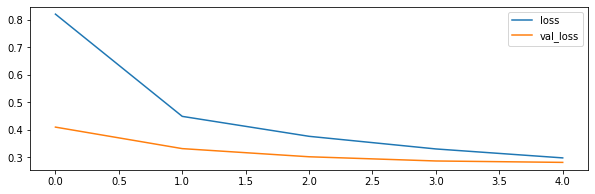

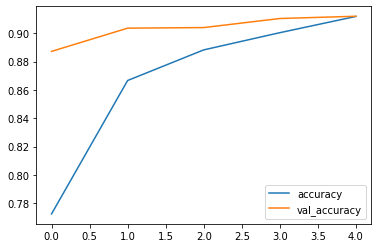

In [ ]:
# Plotting loss and accuracy cureves for efficientnet

loss = efficientnet_history.history["loss"]
val_loss = efficientnet_history.history["val_loss"]

accuracy = efficientnet_history.history["accuracy"]
val_accuracy = efficientnet_history.history["val_accuracy"]

num_of_epochs = range(len(loss))

plt.figure(figsize = (10,3))

plt.plot(num_of_epochs,loss,label = "loss")
plt.plot(num_of_epochs,val_loss,label = "val_loss")
plt.legend()

plt.figure()
plt.plot(num_of_epochs,accuracy,label = "accuracy")
plt.plot(num_of_epochs,val_accuracy,label = "val_accuracy")
plt.legend()

In [ ]:
# Uploading Tensorboard results

!tensorboard dev upload --logdir ./tensorflow_hub/\
  --name "Efficientnet vs Resnet"\
  --description "Comparing Resnet and EfficientNet for food classification"\
  --one_shot

2021-05-13 21:09:55.396846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [ ]:

# Function to predict

def load_image(file_name,input_shape = 224):

  # read file
  img = tf.io.read_file(file_name)

  # decode into tensor

  img = tf.image.decode_image(img)

  # resize 

  img = tf.image.resize(img,size = [input_shape,input_shape])

  # rescale 

  img = img/255.

  return img


# predict and plot funcution

def pred_and_plot(model,file_name,class_names = class_names):

  img = load_image(file_name)

  pred = model.predict(tf.expand_dims(img,axis = 0))

  pred_class = class_names[tf.argmax(pred[0])]

  plt.imshow(img)
  plt.title(pred_class)

  plt.axis("off")

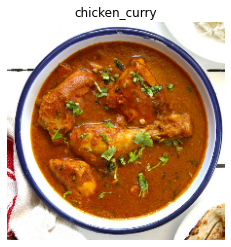

In [ ]:
# pred_and_plot(efficientnet_model,"cc111.jpg")

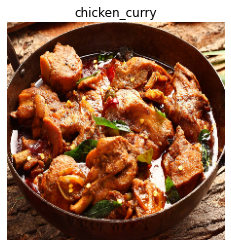

In [ ]:
# pred_and_plot(efficientnet_model,"cc222.jpg")

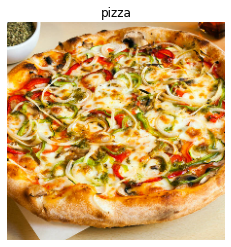

In [ ]:
# pred_and_plot(efficientnet_model,"pizza444.jpg")

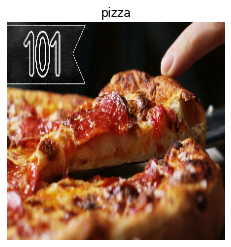

In [ ]:
# pred_and_plot(efficientnet_model,"pizza555.jpg")


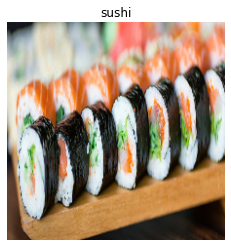

In [ ]:
# pred_and_plot(efficientnet_model,"sss111.jpg")

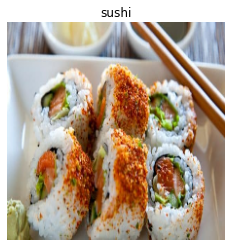

In [ ]:
# pred_and_plot(efficientnet_model,"sss222.jpg")

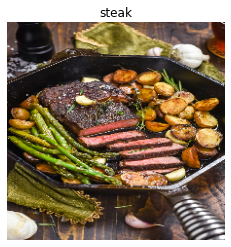

In [ ]:
# pred_and_plot(efficientnet_model,"steak222.jpg")

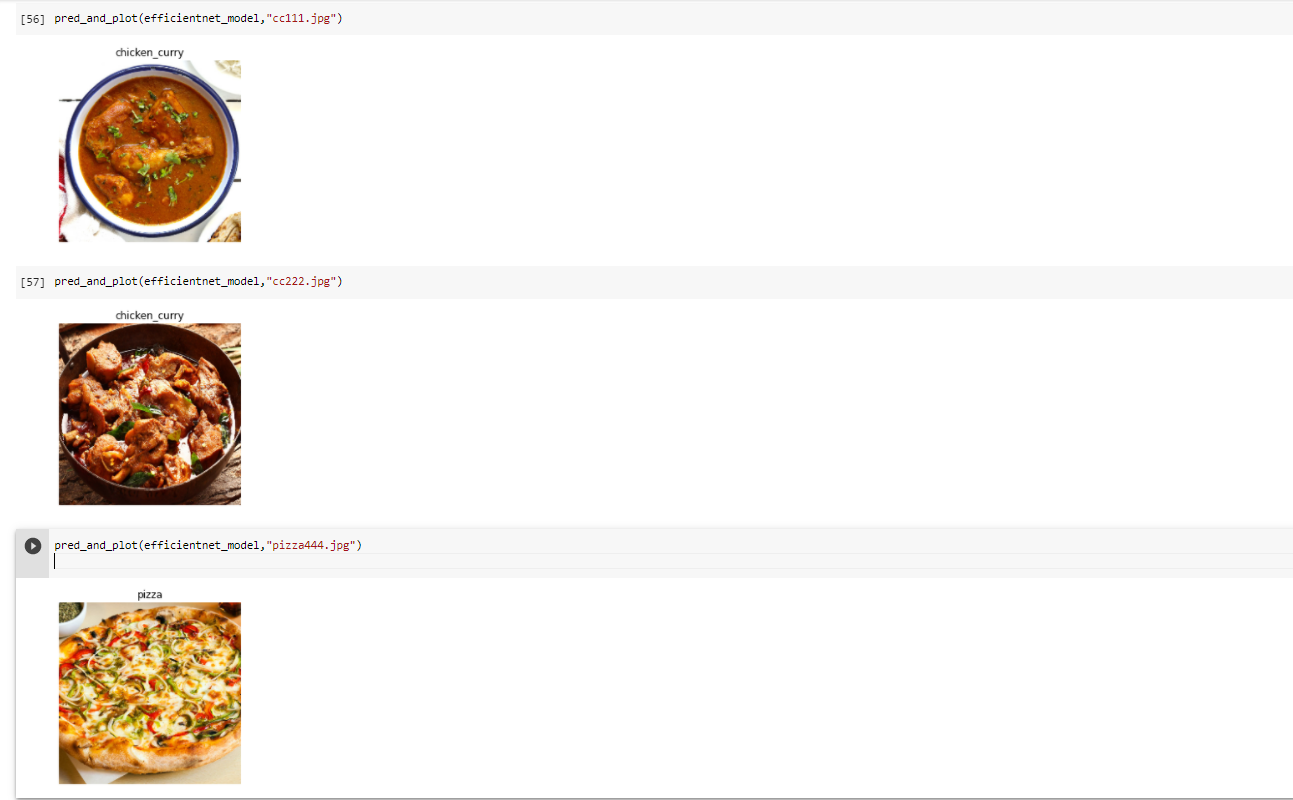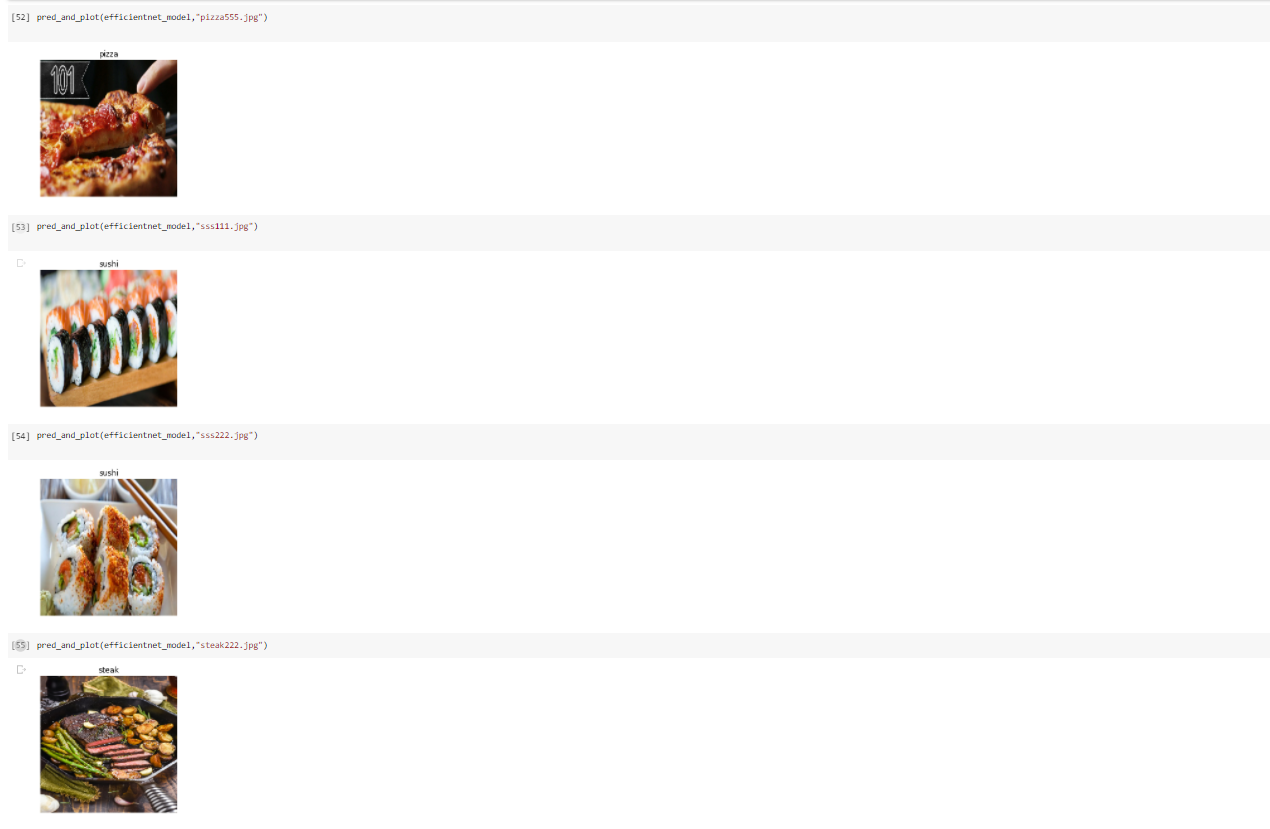

In [ ]:
# We can see that EfficientNet performs very well(accuracy more tha 91%) and we are getting all right answers on our custom images